# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

Processing gedichte.gpt: 100%|██████████| 50/50 [00:01<00:00, 35.56it/s]


✅ Table saved: sentence_length_summary.xlsx


<Figure size 800x500 with 0 Axes>

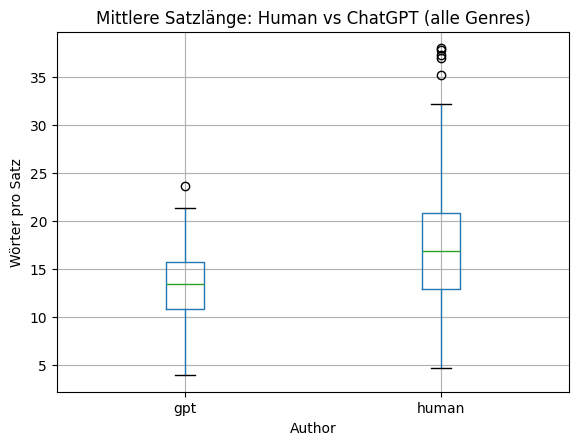

T-test: t=8.061, p=0.0000
✅ Unterschied ist statistisch signifikant (p < 0.05)

📊 Zwei-Wege-ANOVA (Author × Genre):
           Source           SS   DF           MS           F         p-unc  \
0          Author  1750.166651    1  1750.166651  124.918785  2.308446e-25   
1           Genre  2556.899159    3   852.299720   60.833204  2.606317e-32   
2  Author * Genre  2671.890133    3   890.630044   63.569045  1.640296e-33   
3        Residual  5492.090926  392    14.010436         NaN           NaN   

        np2  
0  0.241660  
1  0.317667  
2  0.327278  
3       NaN  

Durchschnittliche Satzlänge pro Genre:
      Genre Author  MeanSentenceLength
0     Essay    gpt           15.258664
1     Essay  human           23.135308
2  Gedichte    gpt           13.071162
3  Gedichte  human           12.465060
4      News    gpt           15.944696
5      News  human           14.773251
6     Posts    gpt            7.968721
7     Posts  human           18.603622


In [1]:
import pandas as pd
import spacy
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import pingouin as pg


nlp = spacy.load("de_core_news_sm")

base_path = Path(r"C:\Users\LizaG\Desktop")


folders = [
    base_path / "Human.Essay",
    base_path / "EssayGPT",
    base_path / "Human.Posts",
    base_path / "PostsGpt",
    base_path / "Human.News",
    base_path / "NewsGPT",
    base_path / "Human.Gedichte",
    base_path / "Gedichte.GPT",
]


possible_genres = {
    "essay": "Essay",
    "news": "News",
    "posts": "Posts",
    "gedichte": "Gedichte"
}

data = []


for folder in folders:
    if not folder.exists():
        print(f"⚠️ Folder not found: {folder}")
        continue

    folder_name = folder.name.lower()


    author = "human" if "human" in folder_name else "gpt"


    genre = "unknown"
    for key, val in possible_genres.items():
        if key in folder_name:
            genre = val
            break


    for filepath in tqdm(list(folder.glob("*.txt")), desc=f"Processing {folder_name}"):
        text_id = filepath.stem
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read().strip()

        doc = nlp(text)
        sentence_lengths = [
            len([t for t in sent if not t.is_punct and not t.is_space])
            for sent in doc.sents
            if len(sent) > 0
        ]

        if len(sentence_lengths) > 0:
            data.append({
                "Folder": folder_name,
                "TextID": text_id,
                "Author": author,
                "Genre": genre,
                "NumSentences": len(sentence_lengths),
                "MeanSentenceLength": sum(sentence_lengths) / len(sentence_lengths),
                "StdSentenceLength": pd.Series(sentence_lengths).std()
            })


df = pd.DataFrame(data)
df.to_excel("sentence_length_summary.xlsx", index=False)
print("✅ Table saved: sentence_length_summary.xlsx")


plt.figure(figsize=(8,5))
df.boxplot(column="MeanSentenceLength", by="Author")
plt.title("Mittlere Satzlänge: Human vs ChatGPT (alle Genres)")
plt.suptitle("")
plt.ylabel("Wörter pro Satz")
plt.show()


from scipy.stats import ttest_ind
human = df[df["Author"]=="human"]["MeanSentenceLength"]
gpt = df[df["Author"]=="gpt"]["MeanSentenceLength"]
t, p = ttest_ind(human, gpt, equal_var=False)
print(f"T-test: t={t:.3f}, p={p:.4f}")
if p < 0.05:
    print("✅ Unterschied ist statistisch signifikant (p < 0.05)")
else:
    print("❌ Kein signifikanter Unterschied (p ≥ 0.05)")


anova = pg.anova(dv="MeanSentenceLength", between=["Author", "Genre"], data=df, detailed=True)
print("\n📊 Zwei-Wege-ANOVA (Author × Genre):")
print(anova)


summary = df.groupby(["Genre", "Author"])["MeanSentenceLength"].mean().reset_index()
print("\nDurchschnittliche Satzlänge pro Genre:")
print(summary)